# Mini-projeto - SOMPY

## Introdução

Este diário do Jupyter é referente ao mini-projeto da disciplina de Redes Neurais envolvendo o uso de mapas auto-organizáveis, ou, do inglês *Self-organizing maps* (*SOM*) utilizando linguagem Python e seguindo o roteiro proposto no [artigo do *Towards Data Science*](https://towardsdatascience.com/analyzing-climate-patterns-with-self-organizing-maps-soms-8d4ef322705b).
 
**Equipe:**


**Pedro Beltran** (@pedrovbeltran) e
**Luana Silva** (@luana-leticia)


**Nota:** algumas partes (incluindo também alguns erros gerados no decorrer do processo) foram omitidas (pois acrescentariam várias linhas ao relatório final) para facilitar a objetividade deste.

## Dia 1

Seguindo o roteiro proposto, precisamos instalar o módulo SOMPY no computador, clonando o repositório https://github.com/hhl60492/SOMPY_robust_clustering. E tentando instalar o módulo pela primeira vez se produziram alguns erros relativos às funções do módulo, que estavam incompatíveis com o programa modificado (o repositório foi clonado e então modificado por outro usuário para esse projeto específico). Além, é claro, de aparecerem muitos erros devido a outros módulos requeridos pelo SOMPY e também devido à API do Google Maps que o projeto usa.

## Dia 2

Depois de exaustiva busca na internet por respostas e pela análise do problema verificamos que o problema ocorreu devido a um conflito da instalação do SOMPY com os arquivos que foram gerados no computador do usuário que fez as modificações e que estavam no repositório (o dono do repositório já foi avisado desse erro e já foi feito um *pull-request* para corrigí-lo). Então, com o problema resolvido, o código corrigido e o módulo instalado de acordo com o roteiro proposto, chegou a hora de testar a execução do programa.

In [1]:
import numpy as np
from sompy.sompy import SOMFactory
import pandas as pd
import glob
import os

# read in all csvs from folder
path = '/home/pedro/Prog/RN/SOM/Diário/SOMPY_robust_clustering/data' # Here you put your unique path to the folder
all_files = glob.glob(os.path.join(path, "*.csv"))

# concat into one df
df_from_each_file = (pd.read_csv(f, skiprows = 31) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# get columns Lat, Long, Mean Temp, Max Temp, Min temp, Precipitation
data = concatenated_df[['Lat', 'Long', 'Tm', 'Tx', 'Tn', 'P']]
data = data.apply(pd.to_numeric,  errors='coerce')
data = data.dropna(how='any')
names = ['Latitude', "longitude", 'Monthly Median temperature (C)','Monthly Max temperature (C)', 'Monthly Min temperature (C)', 'Monthly total precipitation (mm)']

print(data.head())

      Lat     Long    Tm    Tx   Tn      P
0  48.935 -123.742  16.7  28.0  7.0   75.1
1  48.824 -124.133  16.5  32.0  6.0  169.4
2  48.829 -124.052  17.8  33.5  5.0  108.2
4  48.735 -123.728  16.1  30.0  5.0   68.2
5  48.432 -123.439  13.6  21.4  7.1   32.2


Vemos então que, nessa primeira parte de programa, temos apenas a aquisição dos dados que serão usados no decorrer do programa.

In [2]:
# create the SOM network and train it. You can experiment with different normalizations and initializations
sm = SOMFactory().build(data.values, normalization = 'var', initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=2, train_finetune_len=5)

# The quantization error: average distance between each data vector and its BMU.
# The topographic error: the proportion of all data vectors for which first and second BMUs are not adjacent units.
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.08204911417701087; Quantization error = 0.5591334189558947


Nessa outra parte do programa temos a criação e o treinamento da rede propriamente ditos, usando uma técnica de redução de dimensionalidade não-linear chamada no programa de *PCA* (do inglês *Principal Component Analysis* ou, em pt-br, análise dos componentes principais) que é justamente o que permite que a rede consiga dividir o conjunto de dados em grupos usando o conceito de aprendizado competitivo.

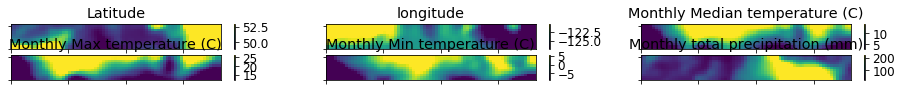

In [12]:
%matplotlib inline

# component planes view
from sompy.visualization.mapview import View2D
view2D  = View2D(10,10,"rand data",text_size=12)
view2D.show(sm, col_sz=3, which_dim="all", desnormalize=True)

Acima foram plotados os *heatmaps* e agora plotaremos a *U-matrix* abaixo:

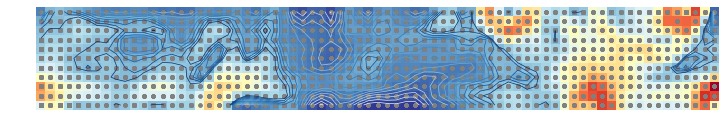

In [13]:
%matplotlib inline

# U-matrix plot
from sompy.visualization.umatrix import UMatrixView

umat  = UMatrixView(width=10,height=10,title='U-matrix')
umat.show(sm)

Com relação à *U-matrix* obtivemos resultados semelhantes aos obtidos pelo usuário criador do programa. Agora, usando o algoritmo K-médias (ou *K-Means*) temos:

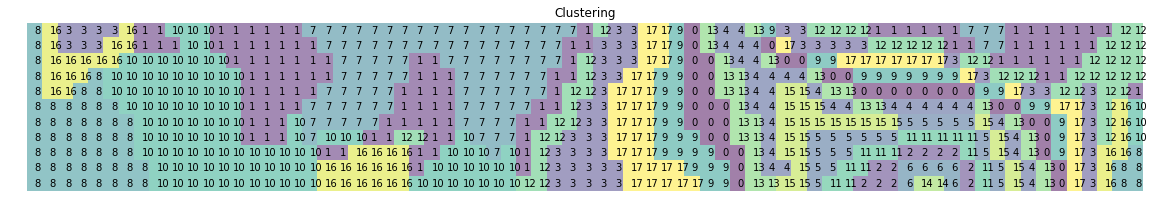

In [14]:
# do the K-means clustering on the SOM grid, sweep across k = 2 to 20
from sompy.visualization.hitmap import HitMapView
K = 20 # stop at this k for SSE sweep
K_opt = 18 # optimal K already found
[labels, km, norm_data] = sm.cluster(K,K_opt)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(sm)

Observamos acima que obtemos a posição dos centróides de cada grupo formado pela rede. Plotando agora essas centróides no *Google Maps* temos:

In [16]:
import gmplot

gmap = gmplot.GoogleMapPlotter(54.2, -124.875224, 6)
j = 0
for i in km.cluster_centers_:
    gmap.marker(i[0],i[1],'red', title="Centroid " + str(j))
    j += 1

gmap.draw("centroids_map.html")

Observando o arquivo gerado (centroids_map.html - disponível no repositório do mini-projeto) verificamos que os centróides gerados pela execução do algoritmo são bastante semelhantes aos gerados pelo criador do programa.

Como visto anteriormente, temos alguns pontos a se trabalhar no programa tais como a modificação da biblioteca gmplot, a qual o criador do programa também modificou e não encontramos um jeito de modificar também (ainda), além de um erro ao plotar os *heat-maps*, onde provavelmente é um erro de configuração (altura e largura), coisa que também terá de ser corrigida em um momento posterior.

## Dia 3

Hoje faremos alguns testes apenas para consertar um pequeno erro que ocorreu com a matplotlib que não está maximizando automaticamente os plots dos *heatmaps*, como pudemos notar no dia anterior.

Depois de um pequeno teste usando a "função mágica" (*magic function*) %matplotlib notebook obtivemos uma imagem que já foi plotada maximizada. O resultado está logo abaixo:

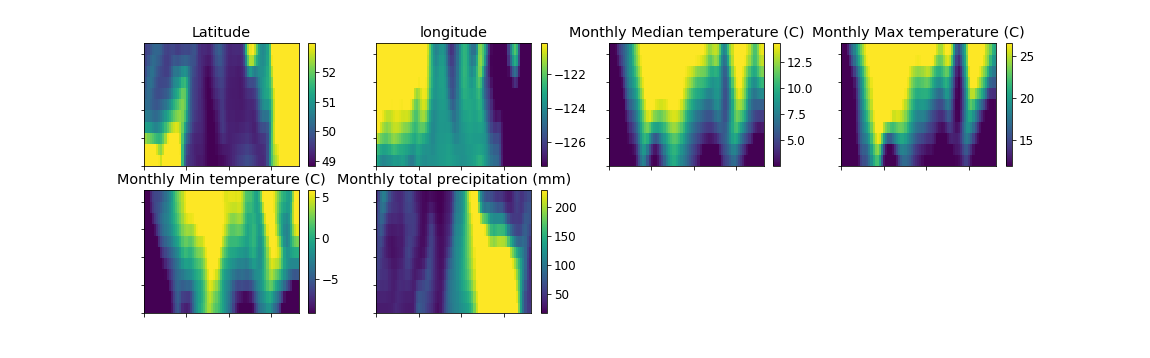

In [1]:
from IPython.display import Image
Image("heatmap.png")

Depois apenas faltava o conserto do pequeno problema da API do Google Maps que, por algum motivo, o plot dos centróides não estava igual ao do artigo. Após uma análise rápida e nova execução do programa, percebeu-se que era devido ao módulo gmplot que o autor do artigo e criador do programa tinha modificado para incluir o nome dos centróides. Após a modificação obteu-se o seguinte resultado:

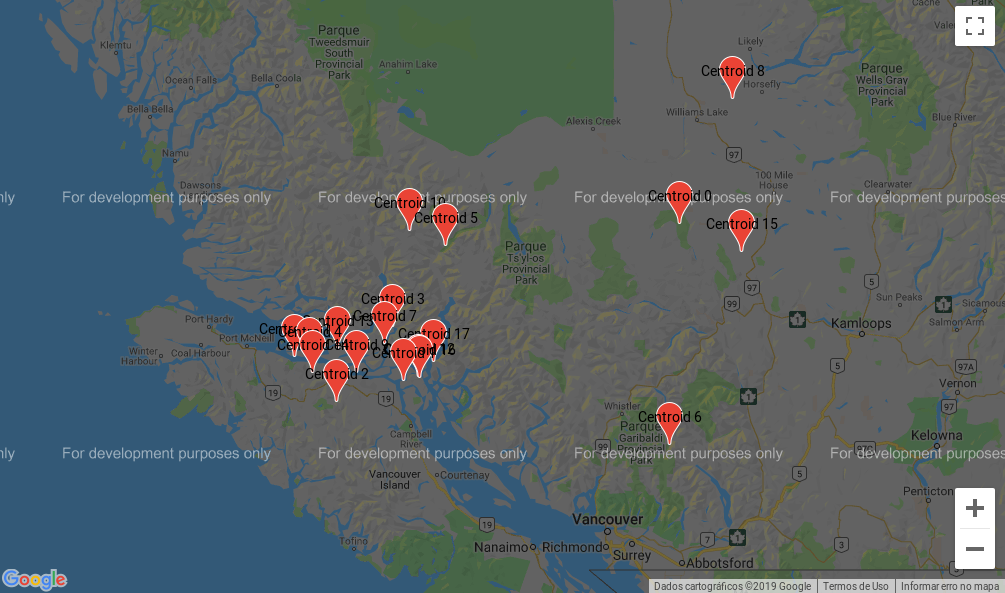

In [2]:
from IPython.display import Image
Image("new_centroids_map.png")

Agora sim obtivemos os resultados esperados. Com isso podemos chegar a algumas conclusões importantes principalmente com relação aos métodos usados, à matriz U (*U-matrix*), aos termos usados no decorrer do programa tais como erro de quantização e erro topográfico e, principalmente, com relação aos grupos (*clusters*) encontrados e qual a interpretação que podemos ter (baseados também nos *heatmaps*) dos resultados.

## Conclusões


Neste projeto, pudemos conhecer o "método do cotovelo" (*elbow's method*) aliado à soma dos erros quadráticos médios (*SSE - Sum of Squared Errors*) para encontrar o número ótimo K de grupos (*clusters*). O método do cotovelo mostra o ponto exato em que o *SSE* é mínimo, e o K encontrado é usado no algoritmo de K-médias (*K-means*) para obtermos os agrupamentos.

A matriz U é um mapa topográfico que mostra o contorno das elevações em toda região. Os "picos" representam pontos distantes da vizinhaça, enquanto os vales, representam as bordas. E então notamos que as regiões com grupos grandes e bem concentrados, como o 1, 7, 8 e 3, apresentam picos mais definidos, então supomos que isso significa que esses grupos devem ter os centróides mais distantes da vizinhaça. Já nos grupos que não tem uma distribuição muito concentrada, isto é, estão mais repartidos, não observamos a ocorrência desses picos.


### Erro de quantização e erro topográfico

Como o artigo [*On quantization error of self-organizing map network*](https://www.sciencedirect.com/science/article/pii/S0925231200002927) escrito por Yi Sun cita, uma aplicação importante do *SOM* é na quantização vetorial, isto é, aproximar uma série de vetores de entrada por meio dos pesos (para formar grupos, ou *clusters*). Portanto, descobrir o quão longe estão os pontos do vetor da *BMU* é importante para verificar a performance da rede, por isso definimos o erro de quantização como a distância média entre cada vetor de entrada e sua respectiva *BMU*.

Como o objetivo principal do uso dos *SOM* é reduzir dimensionalidade criando um mapa topográfico, para medirmos o quão bem está indo o processo usaremos o erro topográfico para avaliar a estrutura do mapa gerado para observar se este é um bom modelo a ser usado para os dados em questão, mais especificamente para detectar discontinuidades no processo de mapeamento. Usando uma definição mais formal, o erro topográfico mede a diferença entre a resposta da primeira e a segunda *BMUs*, se não estiverem próximas, a resposta é contada como erro; após realizar esse processo com todos os vetores de entrada, o número de erros é dividido pelo número total de vetores de entrada.

**Nota:** Como a resposta para essas perguntas não foi trivial, tivemos de recorrer a uma tese intitulada [*Evaluating Self-Organizing Map Quality Measuresas Convergence Criteria*](https://digitalcommons.uri.edu/cgi/viewcontent.cgi?article=2013&context=theses) escrita por Gregory T. Breard.


## Análise dos *heatmaps*

Com os heatmaps, conseguimos separar as características dos dados e avaliá-las individualmente, e com isso, fizemos inferências e achamos relações entre elas.

Primeiro, fizemos uma espécie de "mapeamento das características", que foi identificar como a temperatura (média, mínima e máxima) e a precipitação se comportam em relação à latitude e à longitude:

As temperaturas médias maiores são em torno de 12,5 °C e ocorrem principalmente na faixa de 49-50°N de latitude e faixa de -124 a -120° de longitude. As temperaturas médias menores ocorrem com mais frequência a 54°N de latitude, e não apresentaram um padrão para as longitudes.

As temperaturas máximas maiores são em média 27°C e ocorrem principalmente a 49°N de latitude e na faixa de -124 a -120° de longitude. 

As menores temperaturas mínimas são em média -9°C e ocorrem nas latitudes de 51 a 54°N, e longitude de -123 a -121° (mas com ocorrência em outras longitudes).

As maiores precipitações totais são de 225mm, em média, e ocorrem em latitudes de 54°N mas também ocorrem em latitudes de 50°N, e em longitudes de -128° mas também em longitudes de -124°.
E as menores precipitações totais são de 40mm, em média, e ocorrem principalmente à latitude de 49°N e longitude de -123°.

Agora, vejamos algumas relações entre as características:
A temperatura média mensal está bem correlacionada com a temperatura máxima mensal. Isto confirma a nossa intuição de que lugares com as maiores temperaturas máximas também apresentarão médias de temperaturas maiores.

A temperatura mínima tem uma relação com a temperatura máxima, principalmente nas latitudes de 49 a 50°N, indicando uma região de amplitude média de temperatura alta nessa faixa. 

Também nessa região de amplitudes de temperatura maiores, a precipitação total é menor, em torno de 50mm. E na região complementar, a precipitação total é maior.

E essas foram as muitas inferências que pudemos fazer, e percebemos que algumas se assemelham as feitas pelo autor do artigo. Concluimos que muitas informações podem ser tiradas dos heatmaps através de um algoritmo de aprendizagem relativamente rápido como o SOM. E assim finalizamos o mini-projeto.